In [31]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [32]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import models, transforms

In [33]:
import torch.utils.data as data
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image, ImageReadMode, write_file, write_jpeg

In [489]:
import pandas as pd
import glob
import os
import PIL
from PIL import Image
import copy

## Loading Dataset

In [41]:
voc_path = "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T"

In [120]:
#index_path = "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T"

In [98]:
label_names = "/class_names.txt"
input_images = "/JPEGImages"
seg_masks = "/SegmentationClassPNG"

In [99]:
image_names = glob.glob(voc_path + input_images + "/*")
mask_names = glob.glob(voc_path + seg_masks + "/*")

In [100]:
#list to store image names into a dataframe
image_index = []
mask_index = []
#loop through all image and mask names and extract each image's and mask's name and append it to a list
for item in [image_names, mask_names]:
    for i_names in item:
        #get image name
        img_name = os.path.basename(i_names)
        if item == image_names:
            image_index.append(img_name)
        else:
            mask_index.append(img_name)
        #print(i_names)
#storing the index in a dataframe
df_index['image_index'] = pd.DataFrame(image_index)
df_index['mask_index'] = pd.DataFrame(mask_index)

In [101]:
df_index.head()
#df_index.iloc[4, 0]

,0,image_index,mask_index
0,IMG_2978.jpg,IMG_2978.jpg,IMG_2777.png
1,IMG_2788.jpg,IMG_2788.jpg,IMG_2978.png
2,IMG_2950.jpg,IMG_2950.jpg,IMG_2944.png
3,IMG_2944.jpg,IMG_2944.jpg,IMG_2950.png
4,IMG_2777.jpg,IMG_2777.jpg,IMG_2788.png


In [103]:
df_index.to_csv("/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T/index")

In [430]:
#Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, images_path, mask_path, index_path, label_names): 
        super(SegmentationDataset, self).__init__()
        
        self.images_path = images_path
        self.mask_path = mask_path
        self.index_path = index_path
        self.label_names = label_names
        self.index = pd.read_csv(self.index_path)
        
        self.transform = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
    def __len__(self):
        length = len(self.index)
        return length
    
    
    def __getitem__(self, idx):
        #here load image and do the transformatoin
        input_image = Image.open(self.images_path + str(self.index.iloc[idx, 2]))
        image = self.transform(input_image)
        #img = im.convert('RGB')
         
        #labels_df = pd.read_csv(self.root_dir+"labels")
        #price = torch.tensor(self.data['price_norm'][idx]) #to tensor
        #price = price.type(torch.FloatTensor) #Converting from Double to Float
        image_mask = Image.open(self.mask_path + str(self.index.iloc[idx, 3]))
        pixel_ids = np.array(image_mask)
        pixel_labels = torch.from_numpy(pixel_ids) #converting numpy array ids to tensor
        labels_ohe = pixel_labels.long() #converting true labels to one hot encoding -- labels to probabilities
        h, w = labels_ohe.size()
        target = torch.zeros(9, h, w)
        for l in range(8): #batch_size=8
            lab_o = labels_ohe[l].long()
            for c in range(9):
                target[c][lab_o == c] = 1
        #classes = [enumerate(self.label_names)
        #classes = pd.DataFrame(class_labels)
        classes = self.label_names
        return image, pixel_labels, target, classes

In [431]:
train_images_path = "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T/JPEGImages/"
mask_path = "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T/SegmentationClassPNG/"
index_path = "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T/index"
label_names = "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T/class_names"

In [432]:
image_index = pd.read_csv(index_path)
image_index.iloc[2, 3]

'IMG_2944.png'

In [433]:
image_mask = Image.open(mask_path + str(image_index.iloc[2, 3]))
pix_ids = np.array(image_mask)
pix_labels = torch.from_numpy(pix_ids)
pix_labels.shape

torch.Size([224, 224])

In [457]:
#Instantiating SegmentationDataset class object
training_dataset = SegmentationDataset(train_images_path, mask_path, index_path, label_names)

In [459]:
train_data, valid_data = random_split(training_dataset, [0.9, 0.1], generator = torch.Generator().manual_seed(42))

In [460]:
#DataLoader
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True)

In [436]:
img, lab, tar, nam = next(iter(train_loader))

In [464]:
imgv, labv, tarv, namv = next(iter(valid_loader))

In [439]:
img1, lab1, tar1, nam1 = training_dataset[1]

In [440]:
tar1.size()

torch.Size([9, 224, 224])

In [399]:
lab_o = lab[0].long()

In [400]:
lab_o = lab[0].long()
h, w = lab_o.size()
target = torch.zeros(9, h, w)
for c in range(9):
    target[c][lab_o == c] = 1

In [401]:
target.size()

torch.Size([9, 224, 224])

In [402]:
l_uni = np.unique(lab[0])
l_uni

array([0., 8.], dtype=float32)

In [195]:
nam[0]

'/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T/class_names'

In [201]:
classes = pd.read_csv("/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Project/VOC_T/class_names.txt", header=None, names=['class_names'])
classes['label_id']=classes.index
classes

,class_names,label_id
0,_background_,0
1,footpath,1
2,zebracrossing,2
3,vehicle,3
4,person,4
5,road,5
6,building,6
7,onion,7
8,tomato,8


In [200]:
len(classes['label_id'])

9

In [4]:
model_coco = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)

Using cache found in /Users/rajendrakumarvechalapu/.cache/torch/hub/pytorch_vision_v0.10.0


In [10]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/rajendrakumarvechalapu/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [208]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

In [209]:
#Intializing the model with best available weights
weights= FCN_ResNet50_Weights.DEFAULT
model_fR = fcn_resnet50(weights=weights)

In [210]:
"""""
for name, param in model.named_parameters():
    print(name)
"""""

'""\nfor name, param in model.named_parameters():\n    print(name)\n'

In [212]:
for name, param in model_fR.named_parameters():
    param.requires_grad=False

In [213]:
for name, param in model_fR.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.0.conv3.weight False
backbone.layer1.0.bn3.weight False
backbone.layer1.0.bn3.bias False
backbone.layer1.0.downsample.0.weight False
backbone.layer1.0.downsample.1.weight False
backbone.layer1.0.downsample.1.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.1.conv3.weight False
backbone.layer1.1.bn3.weight False
backbone.layer1.1.bn3.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn

In [231]:
in_channels = model_fR.classifier[4].in_channels
model_fR.classifier[4] = nn.Conv2d(512, 9, kernel_size=(1,1), stride=1) #here, we are predicting 9 labels for each pixel

in_channels_aux = model_fR.aux_classifier[4].in_channels
model_fR.aux_classifier[4] = nn.Conv2d(in_channels_aux, 9, kernel_size=(1,1), stride=1)

In [232]:
for name, param in model_fR.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.0.conv3.weight False
backbone.layer1.0.bn3.weight False
backbone.layer1.0.bn3.bias False
backbone.layer1.0.downsample.0.weight False
backbone.layer1.0.downsample.1.weight False
backbone.layer1.0.downsample.1.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.1.conv3.weight False
backbone.layer1.1.bn3.weight False
backbone.layer1.1.bn3.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn

In [233]:
model_fR.classifier[4].weight.shape

torch.Size([9, 512, 1, 1])

In [234]:
loss_fn = nn.CrossEntropyLoss()

# Learning rate
lr = 0.01
epochs = 1
momentum = 0.9
weight_decay = 1e-8
optimizer = torch.optim.SGD(model_fR.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

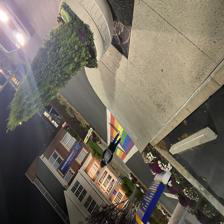

In [316]:
"""""
image_input = Image.open(train_images_path + str(image_index.iloc[1, 2]))
input_image = image_input.convert("RGB")
input_image
"""""

In [471]:
predictions = model_fR(img)['out']
predictions.shape

torch.Size([8, 9, 224, 224])

In [472]:
preds = predictions.argmax(1)
preds.size()

torch.Size([8, 224, 224])

In [473]:
lab.size()

torch.Size([8, 224, 224])

In [444]:
#pred = predictions.argmax(1)
#pred = pred.type(torch.FloatTensor)
#lab = lab.type(torch.FloatTensor)

In [445]:
"""""
h, w = lab[0].size()
target = torch.zeros(9, h, w)
for l in range(8): #batch_size=8
    lab_o = lab[l].long()
    for c in range(9):
        target[c][lab_o == c] = 1
"""""

'""\nh, w = lab[0].size()\ntarget = torch.zeros(9, h, w)\nfor l in range(8): #batch_size=8\n    lab_o = lab[l].long()\n    for c in range(9):\n        target[c][lab_o == c] = 1\n'

In [450]:
tar[0].shape

torch.Size([9, 224, 224])

In [447]:
predictions.shape

torch.Size([9, 224, 224])

In [455]:
loss = loss_fn(predictions, tar)
loss

tensor(2.2622, grad_fn=<DivBackward1>)

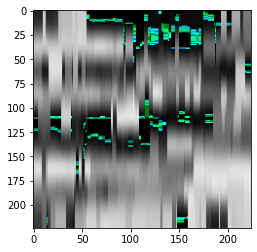

In [313]:
# create a color pallette, selecting a color for each class---for 9 classes
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(9)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 9 classes in each color
r = Image.fromarray(pred.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

In [296]:
loss = loss_fn(pred, lab)
loss

tensor(1376.4779)

In [476]:
def iou(pred, target):
    ious = []
    for cls in range(9):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
        # print("cls", cls, pred_inds.sum(), target_inds.sum(), intersection, float(intersection) / max(union, 1))
    return ious


def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [495]:
model_fR.train()
total_ious = []
pixel_accs = []
epoch_ious = []
epoch_accs = []

best_model_wts = copy.deepcopy(model_fR.state_dict())
best_iou = 0.0

for epoch in range(5): #number of epochs
    total_ious.clear()
    pixel_accs.clear()
    for batch in iter(train_loader):
        model_fR.zero_grad()
        images, pixel_labels,target_labels, class_names = batch
        predictions = model_fR(images)['out'] 
        #pred_labels = predictions.argmax(1)
        #pred_labels = pred_labels.type(torch.FloatTensor)
        #true_labels = pixel_labels.type(torch.FloatTensor)
        loss = loss_fn(predictions, target_labels)
        loss.backward()
        optimizer.step()


    
    with torch.no_grad():
        model_fR.eval()
        for batch in iter(valid_loader):

            images, pixel_labels,target_labels, class_names = batch

            predictions = model_fR(images)['out']
            prediction_labels = predictions.argmax(1)
            """""
            output = output.data.cpu().numpy()

            N, _, h, w = output.shape
            pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

            target = batch['l'].cpu().numpy().reshape(N, h, w)
            """""
            for p, t in zip(prediction_labels, pixel_labels):
                total_ious.append(iou(p, t))
                pixel_accs.append(pixel_acc(p, t))

        # Calculate average IoU
        total_ious_array = np.array(total_ious).T  # n_class * val_len
        ious = np.nanmean(total_ious_array, axis=1)
        current_epoch_iou = np.nanmean(ious)
        epoch_ious.append(current_epoch_iou)
        pixel_accs_array = np.array(pixel_accs).mean()
        epoch_accs.append(pixel_accs_array)
        #print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}".format(epoch, pixel_accs, np.nanmean(ious), ious))
        print("epoch: {}, pix_acc: {}, meanIoU: {}".format(epoch, pixel_accs_array, current_epoch_iou))
        
        # deep copy the model---saves the model which has highest IOU
        if current_epoch_iou > best_iou: 
            best_iou = current_epoch_iou
            best_model_wts = copy.deepcopy(model_fR.state_dict())
        #IU_scores[epoch] = ious
        #np.save(os.path.join(score_dir, "meanIU"), IU_scores)
        #pixel_scores[epoch] = pixel_accs
        #np.save(os.path.join(score_dir, "meanPixel"), pixel_scores)


        # borrow functions and modify it from https://github.com/Kaixhin/FCN-semantic-segmentation/blob/master/main.py
        # Calculates class intersections over unions


/var/folders/sg/y1f88xp10px2v7dq006_gh1r0000gn/T/ipykernel_4793/2847695827.py:48: RuntimeWarning: Mean of empty slice
  ious = np.nanmean(total_ious_array, axis=1)


epoch: 0, pix_acc: 0.42574140429496765, meanIoU: 0.14529266953468323
epoch: 1, pix_acc: 0.42970743775367737, meanIoU: 0.14692606776952744
epoch: 2, pix_acc: 0.4282924234867096, meanIoU: 0.1463528871536255
epoch: 3, pix_acc: 0.42629942297935486, meanIoU: 0.14553603529930115
epoch: 4, pix_acc: 0.4204599857330322, meanIoU: 0.1431214138865471


In [493]:
print("IOUs of all epochs: ", epoch_ious)
print("Pixel accuracies of all epochs: ", epoch_accs)

IOUs of all epochs:  [array([0.29463655, 0.15566546,        nan,        nan,        nan,
       0.        , 0.        ,        nan,        nan]), array([0.27572662, 0.19623767,        nan,        nan,        nan,
       0.        , 0.        ,        nan,        nan]), array([0.26795572, 0.2475552 ,        nan,        nan,        nan,
       0.        , 0.        ,        nan,        nan]), array([0.27039504, 0.28213346,        nan,        nan,        nan,
       0.        , 0.        ,        nan,        nan]), array([0.27441379, 0.30019358,        nan,        nan,        nan,
       0.        , 0.        ,        nan,        nan])]
Pixel accuracies of all epochs:  [0.35560825, 0.36260363, 0.38639987, 0.40842235, 0.42165577]


In [ ]:
model_path = "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Fine_Tuned_Model/"

In [ ]:
torch.save(best_model_wts, "/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Fine_Tuned_Model/")

In [ ]:
#model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load("/Users/rajendrakumarvechalapu/Desktop/DL_2022/FP_Fine_Tuned_Model/"))
model.eval()